# Task 3 - Explore and analyse embeddings

## Imports

In [263]:
import scanpy as sc
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Joint embedding visualization

In [17]:
# load unperturbed and perturbed datasets
adatas = {
    "unperturbed": sc.read_h5ad("../data/adata_unperturbed_geneformer.h5ad"),
    "knock-up_3genes": sc.read_h5ad("../data/adata_ALS_perturb_3_up_geneformer.h5ad"),
    "knock-down_3genes": sc.read_h5ad("../data/adata_ALS_perturb_3_down_geneformer.h5ad"),
}

/home/ubuntu/.pyenv/versions/3.11.8/envs/helical_coding_challenge/lib/python3.11/site-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/.pyenv/versions/3.11.8/envs/helical_coding_challenge/lib/python3.11/site-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/.pyenv/versions/3.11.8/envs/helical_coding_challenge/lib/python3.11/site-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
# make var index unique for concat and add condition column
adatas["unperturbed"].var.index = adatas["unperturbed"].var["ensembl_id"]
adatas["unperturbed"].obs["dataset"] = adatas["unperturbed"].obs["Condition"].astype(str) + "_unperturbed"

adatas["knock-up_3genes"].var.index = adatas["knock-up_3genes"].var["ensembl_id"]
adatas["knock-up_3genes"].obs["dataset"] = adatas["knock-up_3genes"].obs["Condition"].astype(str) + "_knock-up_3genes"

adatas["knock-down_3genes"].var.index = adatas["knock-down_3genes"].var["ensembl_id"]
adatas["knock-down_3genes"].obs["dataset"] = adatas["knock-down_3genes"].obs["Condition"].astype(str) + "_knock-down_3genes"

In [24]:
# concatenate objects and compute a joint neighbor graph and UMAP representation
adata = ad.concat(adatas, index_unique="_")
sc.pp.neighbors(adata, use_rep="X_geneformer")
sc.tl.umap(adata)

/home/ubuntu/.pyenv/versions/3.11.8/envs/helical_coding_challenge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.pyenv/versions/3.11.8/envs/helical_coding_challenge/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


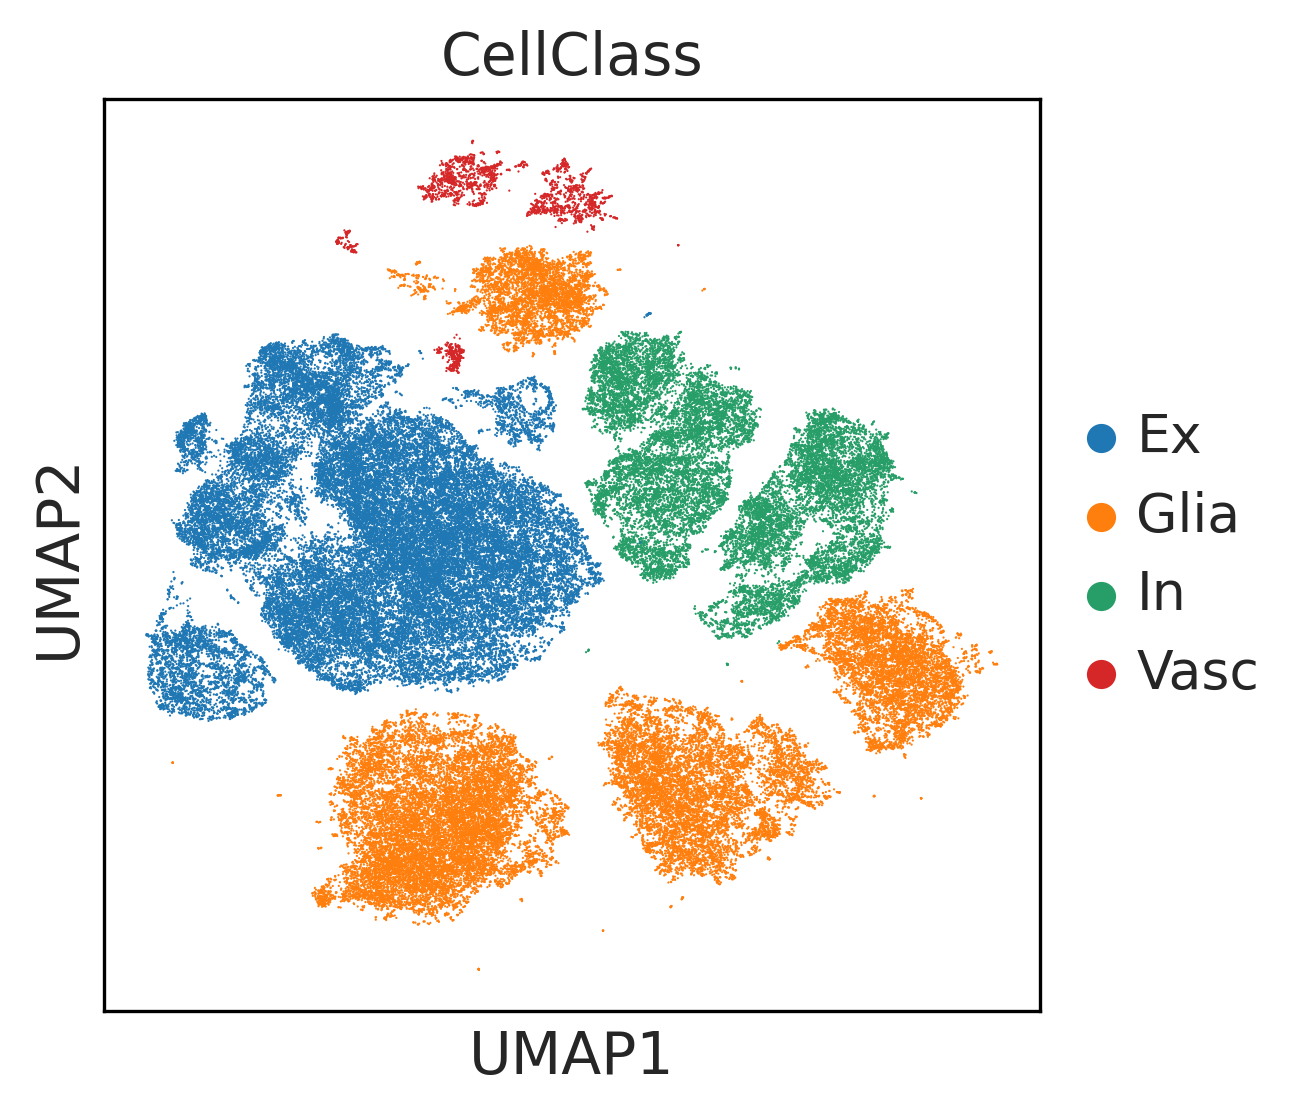

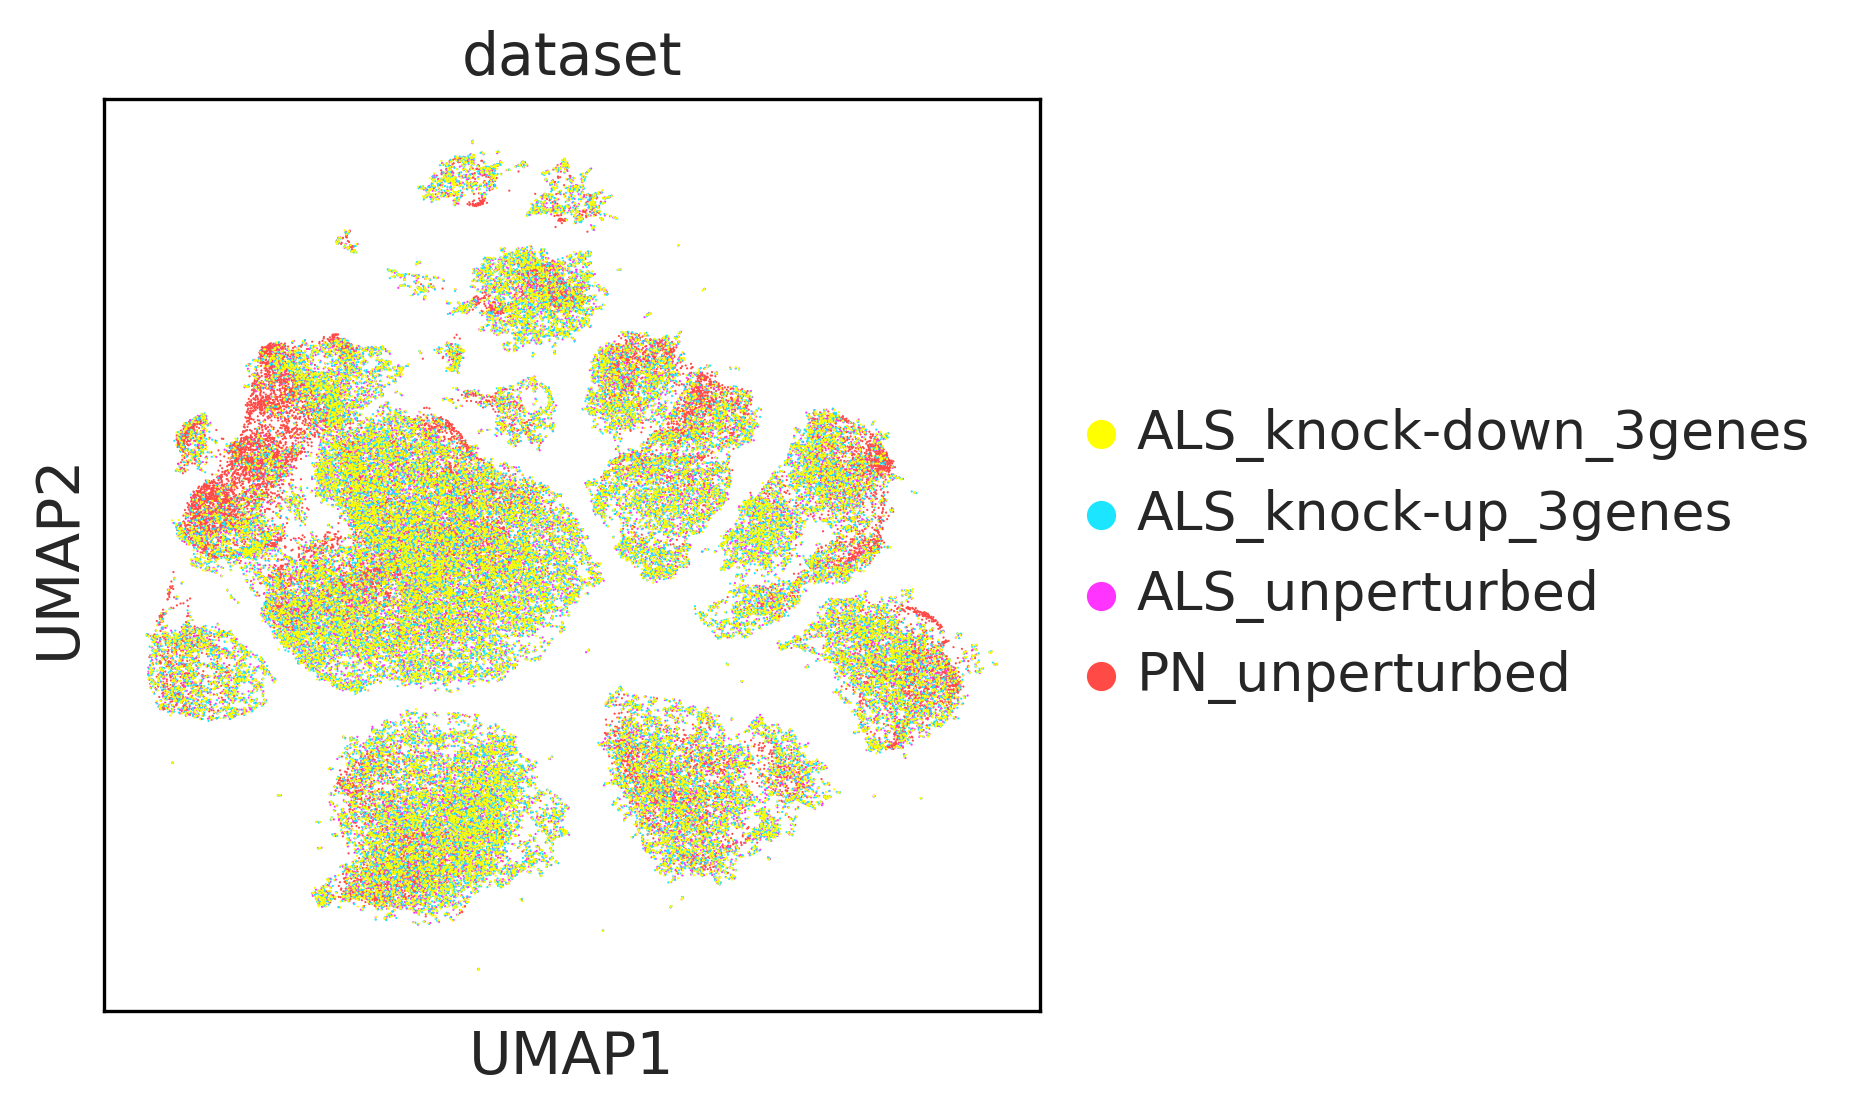

In [213]:
# jointly visualize all conditions 
sc.set_figure_params(dpi=150)
sc.pl.umap(adata, color=["CellClass"], palette=sc.pl.palettes.default_20)
sc.pl.umap(adata, color=["dataset"], palette=sc.pl.palettes.default_102)

## Comparing distances across ALS and perturbed embeddings

In [87]:
# compute the cellwise distance of perturbed cells from unpertubed ALS cells
adata.obs["cell_distance_fromALS"] = np.nan
adata.obs.loc[adata.obs["dataset"] == "ALS_knock-up_3genes", "cell_distance_fromALS"] = np.linalg.norm(adata[adata.obs["dataset"] == "ALS_knock-up_3genes"].obsm["X_geneformer"] - adata[adata.obs["dataset"] == "ALS_unperturbed"].obsm["X_geneformer"], axis=1)
adata.obs.loc[adata.obs["dataset"] == "ALS_knock-down_3genes", "cell_distance_fromALS"] = np.linalg.norm(adata[adata.obs["dataset"] == "ALS_knock-down_3genes"].obsm["X_geneformer"] - adata[adata.obs["dataset"] == "ALS_unperturbed"].obsm["X_geneformer"], axis=1)

/tmp/ipykernel_2592203/1151405100.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['ALS_knock-up_3genes', 'ALS_knock-up_3genes', 'ALS_knock-up_3genes', 'ALS_knock-up_3genes', 'ALS_knock-up_3genes', ..., 'ALS_knock-down_3genes', 'ALS_knock-down_3genes', 'ALS_knock-down_3genes', 'ALS_knock-down_3genes', 'ALS_knock-down_3genes']
Length: 57000
Categories (2, object): ['ALS_knock-down_3genes', 'ALS_knock-up_3genes']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, "dataset"] = df["dataset"].cat.remove_unused_categories()
/tmp/ipykernel_2592203/1151405100.py:4: UserWarning: The palette list has more values (102) than needed (2), which may not be intended.
  sns.boxplot(df, x="CellClass", y="cell_distance_fromALS", hue="dataset", palette=sc.pl.palettes.default_102)


<Axes: xlabel='CellClass', ylabel='cell_distance_fromALS'>

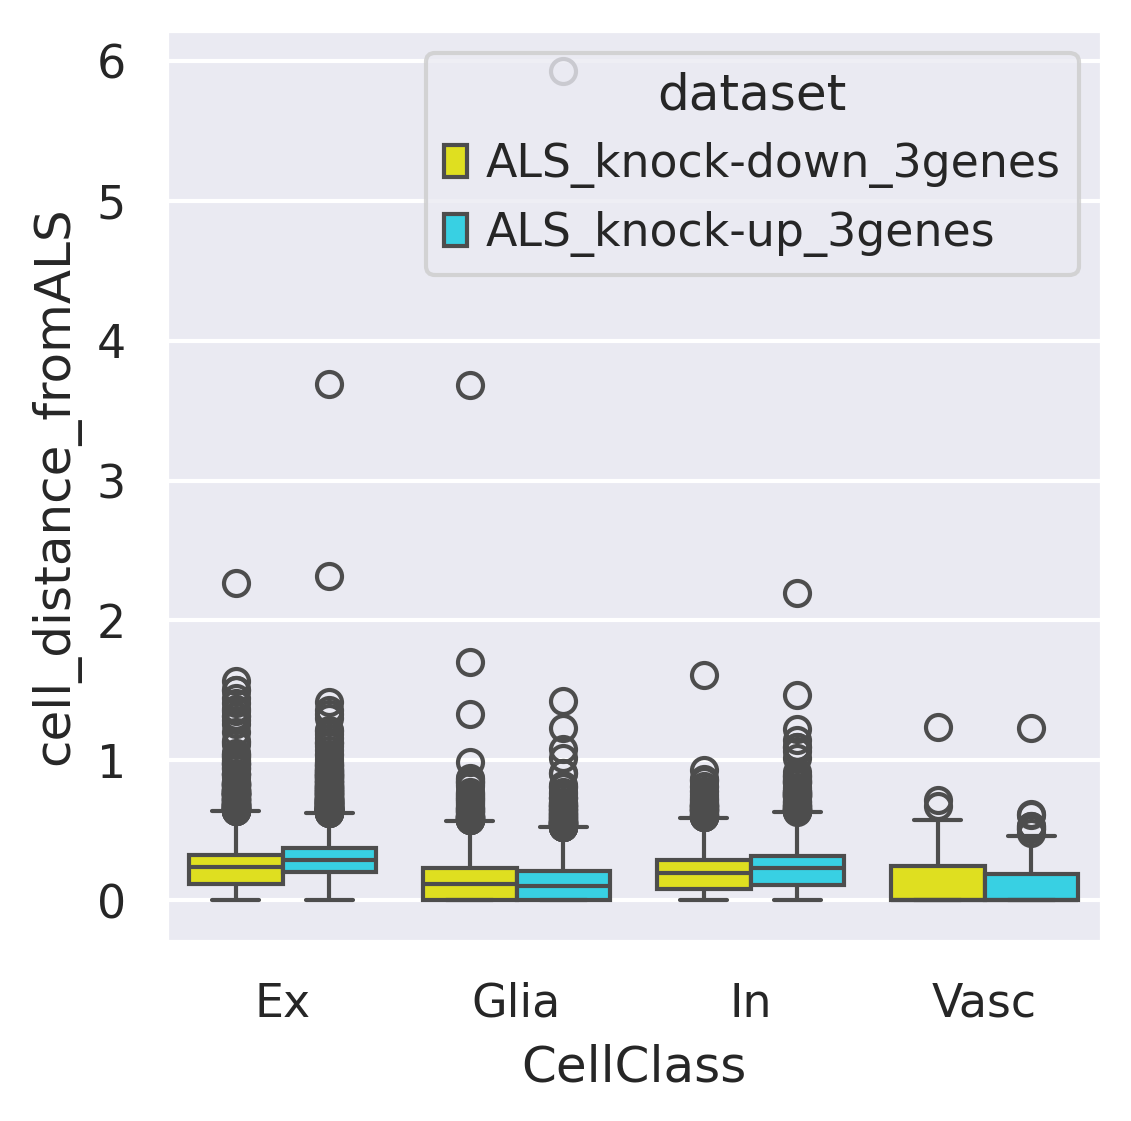

In [320]:
# visualise the euclidean distance distributions in a boxplot
sns.set_theme()
df = adata.obs.loc[adata.obs["dataset"].isin(["ALS_knock-up_3genes", "ALS_knock-down_3genes"])]
df.loc[:, "dataset"] = df["dataset"].cat.remove_unused_categories()
sns.boxplot(df, x="CellClass", y="cell_distance_fromALS", hue="dataset", palette=sc.pl.palettes.default_102)

## Distance to healthy CellClass centroids

In [217]:
# compute distance of every perturbed cell to it's matching healthy control celltype cluster centroid
adata.obs["cell_distance_fromPNmean"] = np.nan

adata.obs["cell_distance_fromPNmean"] = pd.concat([
    pd.Series(np.linalg.norm((adata[(adata.obs["dataset"] == "ALS_knock-up_3genes") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"] -\
                              adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"].mean(axis=0)), axis=1),
              index=adata[(adata.obs["dataset"] == "ALS_knock-up_3genes") & (adata.obs["CellClass"] == ct)].obs_names) \
    for ct in adata.obs["CellClass"].cat.categories
]+[
    pd.Series(np.linalg.norm((adata[(adata.obs["dataset"] == "ALS_knock-down_3genes") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"] -\
                              adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"].mean(axis=0)), axis=1),
              index=adata[(adata.obs["dataset"] == "ALS_knock-down_3genes") & (adata.obs["CellClass"] == ct)].obs_names) \
    for ct in adata.obs["CellClass"].cat.categories
]+[
    pd.Series(np.linalg.norm((adata[(adata.obs["dataset"] == "ALS_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"] -\
                                     adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"].mean(axis=0)), axis=1),
              index=adata[(adata.obs["dataset"] == "ALS_unperturbed") & (adata.obs["CellClass"] == ct)].obs_names) \
    for ct in adata.obs["CellClass"].cat.categories
]+[
    pd.Series(np.linalg.norm((adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"] -\
                                     adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"].mean(axis=0)), axis=1),
              index=adata[(adata.obs["dataset"] == "PN_unperturbed") & (adata.obs["CellClass"] == ct)].obs_names) \
    for ct in adata.obs["CellClass"].cat.categories
]).loc[adata.obs_names]

dataset,ALS_knock-down_3genes,ALS_knock-up_3genes,ALS_unperturbed
CellClass,,,
Ex,0.514306,0.513633,0.514257
Glia,-0.126053,-0.123461,-0.122856
In,0.246425,0.247611,0.247246
Vasc,-0.132204,-0.130901,-0.130020


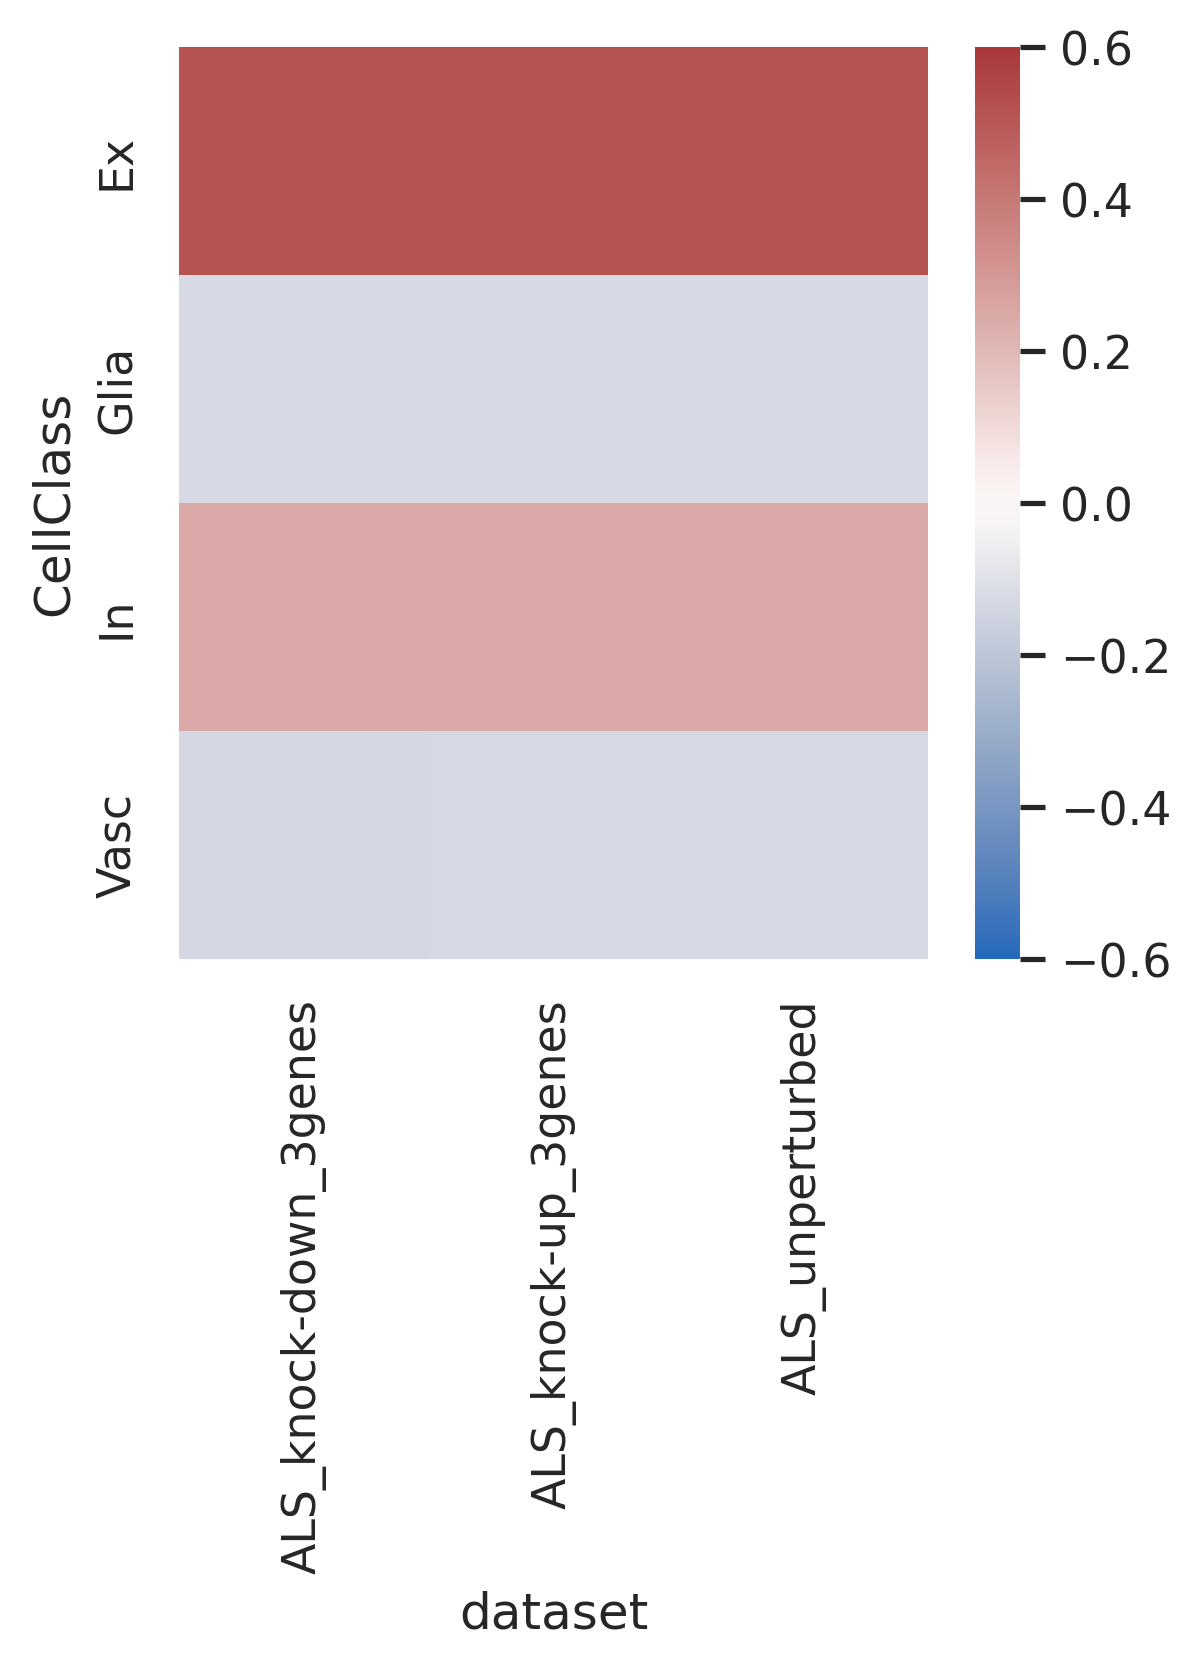

In [218]:
# subtract the mean distance per centroid in healthy data and visualise
# negative values describe conditions where the average distance from the healthy centroid is smaller than the average distance of that CellClass to the centroid in the healthy data
sns.set_theme()
similarities = adata.obs.pivot_table(index="CellClass", columns="dataset", values="cell_distance_fromPNmean", aggfunc="mean", observed=True)
similarities = similarities.iloc[:, :3]-similarities[["PN_unperturbed"]].values
display(similarities)
sns.heatmap(similarities, cmap="vlag", vmin=-0.6, vmax=0.6);

## Neighborhood purity analysis

In [278]:
# compute 10 nearest neighbors per cell
sc.pp.neighbors(adata, n_neighbors=10, key_added="10nn", use_rep="X_geneformer")

In [279]:
# for each cell, compute the neighborhood composition with respect to the condition
nbhood_composition = {i: [] for i in adata.obs["dataset"].cat.categories}
for i in tqdm(range(len(adata))):
    counts = adata.obs["dataset"].iloc[adata.obsp["10nn_distances"][i].nonzero()[1]].value_counts()
    for k, v in counts.items():
        nbhood_composition[k].append(v)

# write to adata object obs
for k, v in nbhood_composition.items():
    adata.obs[f"neighbors_{k}"] = v

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107000/107000 [01:18<00:00, 1368.72it/s]


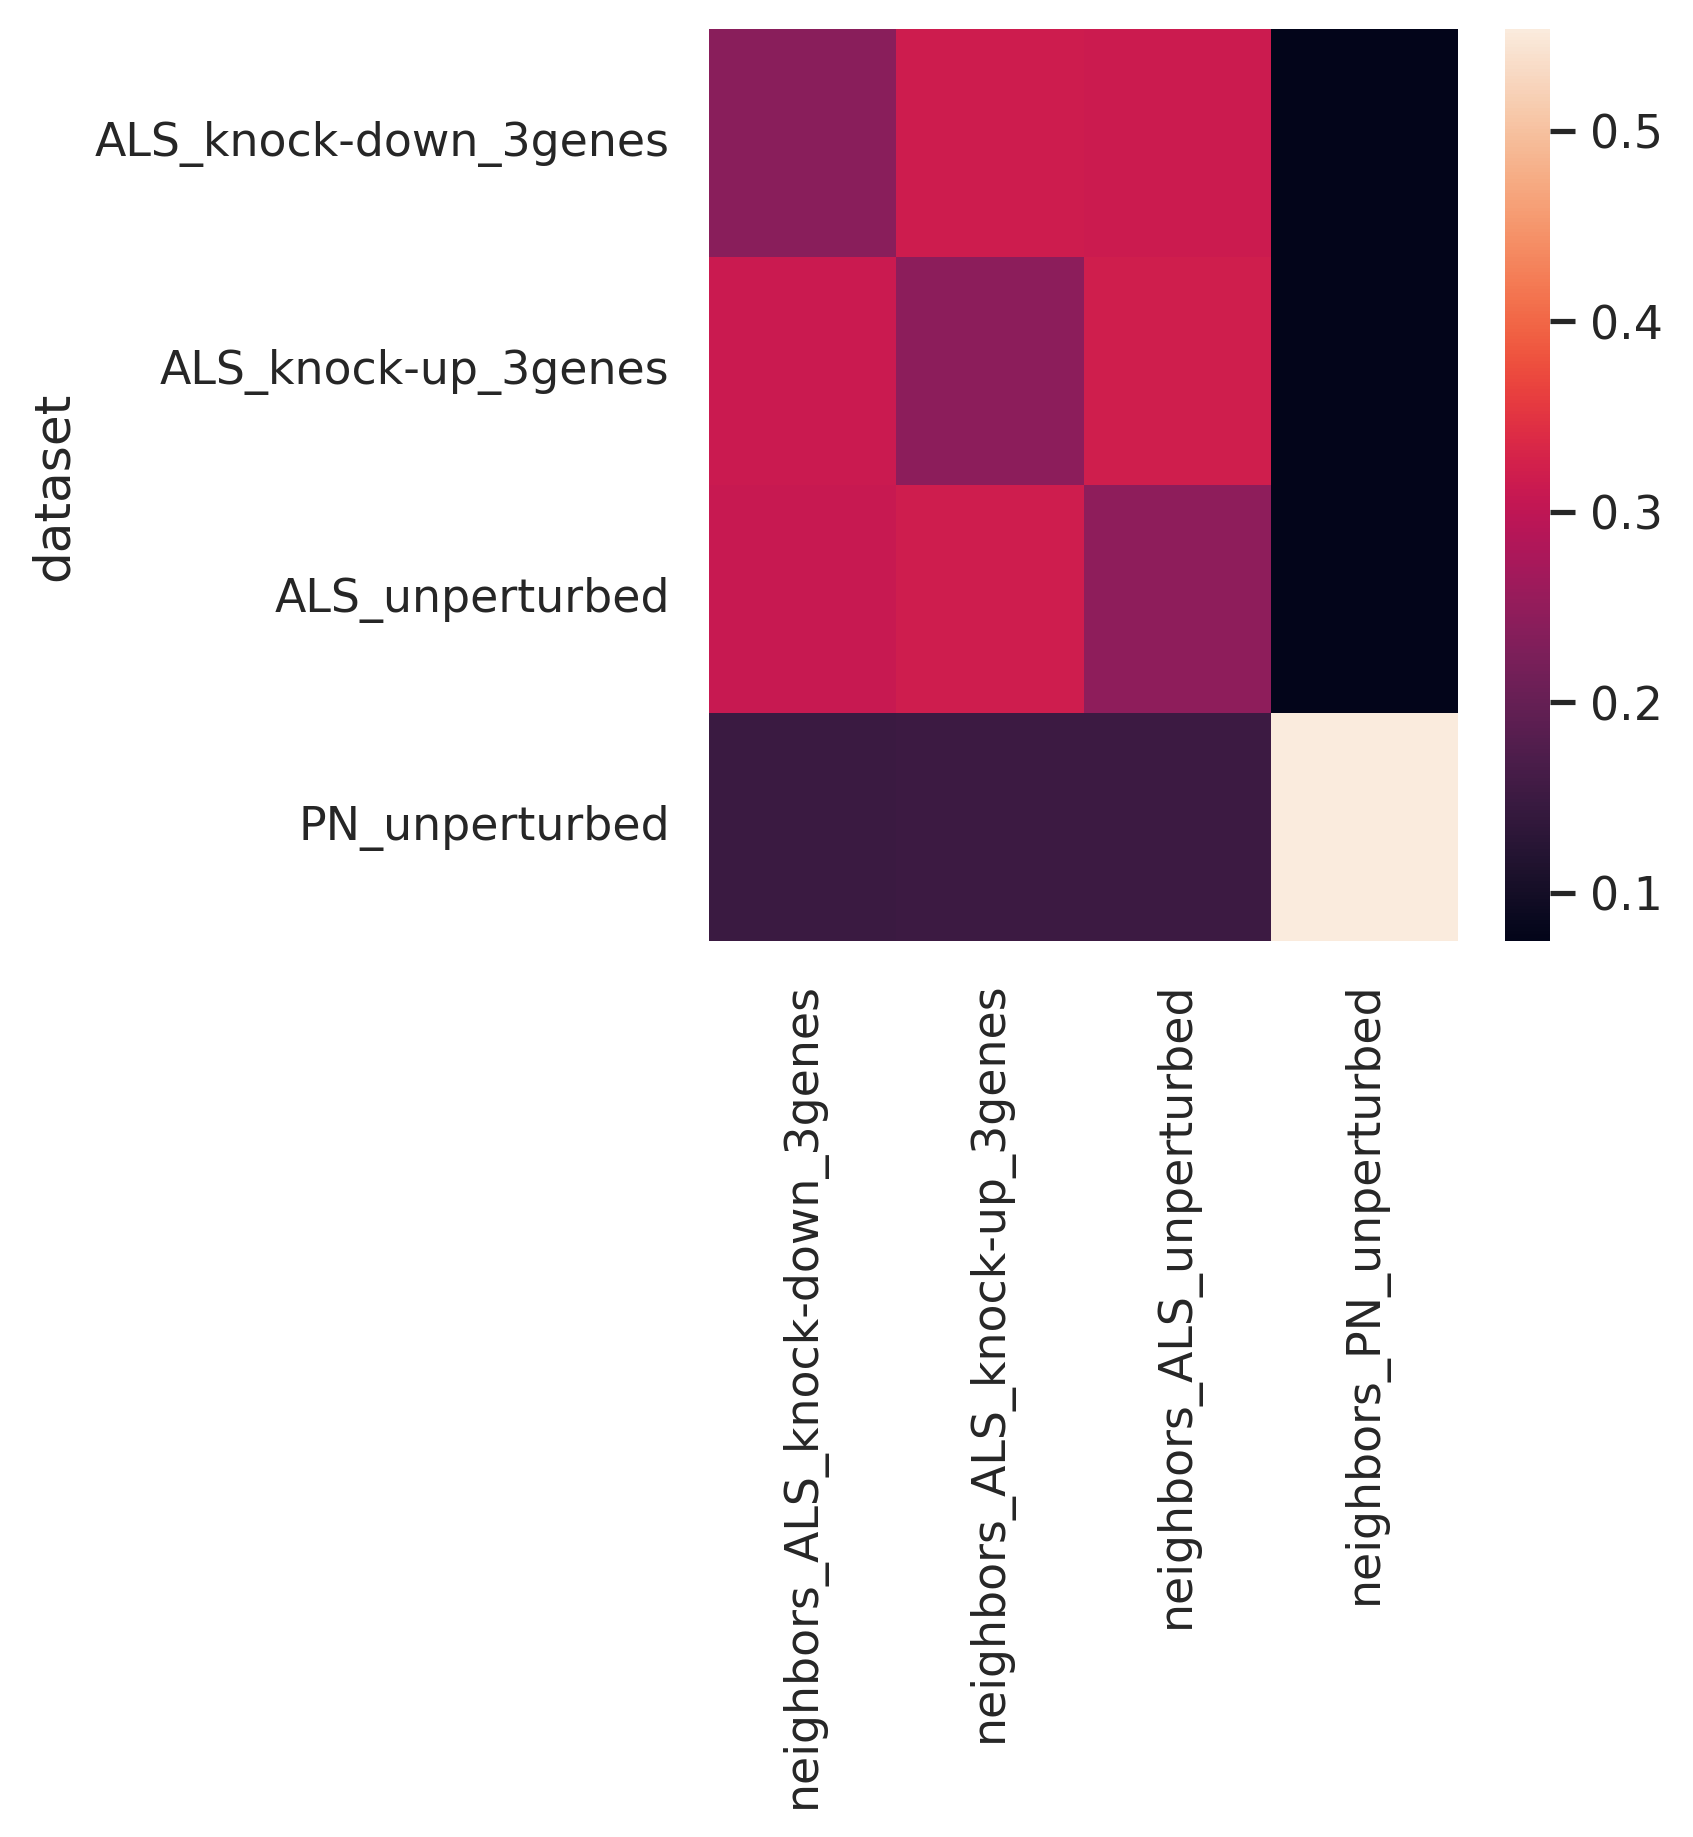

In [284]:
# visualise the condition of origin fractions for each condition
sns.heatmap(adata.obs.groupby("dataset", observed=True)[[f"neighbors_{i}" for i in nbhood_composition.keys()]].mean()/10);